In [31]:
import pandas as pd
import numpy as np
import yfinance as yf
from yahoo_fin.stock_info import *
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.family' : 'sans'})
sm, med, lg = 15, 20, 25
plt.rc('font', size = sm)         # controls default text sizes
plt.rc('axes', titlesize = med)   # fontsize of the axes title
plt.rc('axes', labelsize = med)   # fontsize of the x & y labels
plt.rc('xtick', labelsize = sm)   # fontsize of the tick labels
plt.rc('ytick', labelsize = sm)   # fontsize of the tick labels
plt.rc('legend', fontsize = sm)   # legend fontsize
plt.rc('figure', titlesize = lg)  # fontsize of the figure title
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')
import warnings
warnings.filterwarnings('ignore')

In [51]:
class MovingAverageGenerator(object):
    def __init__(self):
        pass

    def mAvg_trading_signals(self, ticker, period='5y', interval='1d'):
        self.ticker = ticker
        self.period = period
        self.interval = interval
        self.data = yf.download(self.ticker, period = self.period, interval = self.interval)['Adj Close']
        self.df = pd.DataFrame(self.data)
        self.df.fillna(0, inplace = True)
        self.df_daily_close = self.df
        self.df_daily_close.fillna(0, inplace = True)

        self.df_daily_pct_c = self.df_daily_close.pct_change()
        self.df_daily_pct_c.fillna(0, inplace = True)
        self.df_daily_pct_c = self.df_daily_close / self.df_daily_close.shift(1) - 1
        self.df_daily_pct_c.fillna(0, inplace = True)
        self.df['Daily_S_RoR'] = self.df_daily_pct_c * 100  

        # LOG Rate Of Return
        self.df_daily_log_returns = np.log(self.df_daily_close.pct_change() + 1)
        self.df_daily_log_returns.head()
        self.df_daily_log_returns.fillna(0, inplace = True)
        self.df['Daily_Log'] = self.df_daily_log_returns['Adj Close'] * 100 

        # Total Return
        self.df_cum_daily_return = (1 + self.df_daily_pct_c).cumprod()
        self.df['Total_RoR'] = self.df_cum_daily_return
        self.df.rename(columns={'Adj Close': self.ticker}, inplace=True)

        # Build MovingAverages
        self.short_window, self.long_window, self.period, self.multiplier = 20, 50, 20, 2
        self.signals = pd.DataFrame(index=self.df.index)

        self.signals['signal'] = 0.0
        self.signals[self.ticker] = self.df[self.ticker]
        self.signals['short_mavg'] = self.df[self.ticker].rolling(window=self.short_window,min_periods=1,center=False).mean()
        self.signals['long_mavg'] = self.df[self.ticker].rolling(window=self.long_window, min_periods=1, center=False).mean()
        self.signals['UpperBand'] = self.df[self.ticker].rolling(self.period).mean()+self.df[self.ticker].rolling(self.period).std()*self.multiplier
        self.signals['LowerBand'] = self.df[self.ticker].rolling(self.period).mean()-self.df[self.ticker].rolling(self.period).std()*self.multiplier
        self.signals['signal'][self.short_window:]=np.where(
            self.signals['short_mavg'][self.short_window:]>self.signals['long_mavg'][self.short_window:],1.0,0.0)
        self.signals['positions'] = self.signals['signal'].diff()

        fig = plt.figure(figsize=(18, 7), dpi = 75)

        ax1 = fig.add_subplot(111,  ylabel='Price in $')
        self.df[self.ticker].plot(ax=ax1, lw=3., color = 'k')
        ax1.plot(self.signals.short_mavg, '--', color='c', lw=2)
        ax1.plot(self.signals.long_mavg, '--', color='m', lw=2)
        ax1.plot(self.signals.UpperBand, '-', color = 'b', lw=2)
        ax1.plot(self.signals.LowerBand, '-', color = 'b', lw=2)
        ax1.plot(self.signals.loc[
            self.signals.positions == 1.0].index,self.signals.short_mavg[self.signals.positions == 1.0],'^', markersize=20, color = 'k')
        ax1.plot(self.signals.loc[
            self.signals.positions == -1.0].index, self.signals.short_mavg[self.signals.positions == -1.0],'v', markersize=20, color = 'r')
        ax1.vlines(
            self.signals.short_mavg[self.signals.positions == 1.0].index, 
            self.df[self.ticker].min(), self.df[self.ticker].max(), 
            linestyles ="solid", colors ="g", lw=2
            )
        ax1.vlines(
            self.signals.short_mavg[self.signals.positions == -1.0].index, 
            self.df[self.ticker].min(), self.df[self.ticker].max(), 
            linestyles ="solid", colors ="r", lw=2
            )
        ax1.set_title(self.ticker+' - Moving Average Trade Signals SHORT-TERM', fontsize=25)
        ax1.legend(self.signals[[ticker, 'short_mavg','long_mavg','UpperBand','LowerBand']])
        plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
        plt.show()

        print('Time To Buy:\n  ', self.signals.short_mavg[self.signals.positions == 1.0])
        print('\n\nTime To Sell: \n', self.signals.short_mavg[self.signals.positions == -1.0],'\n')
        return self.signals

    def gainers(self):
        self.gainers = (get_day_gainers())
        print(self.gainers.Symbol[:5])
        for g in self.gainers.Symbol[:5]:
            self.signal = self.mAvg_trading_signals(ticker = g)
            print(self.signal.tail(),'\n\n')

    def losers(self):
        self.losers = (get_day_losers())
        print(self.losers.Symbol[:5])
        for l in self.losers.Symbol[:5]:
            self.signal = self.mAvg_trading_signals(ticker = l)
            print(self.signal.tail(),'\n\n')

[*********************100%***********************]  1 of 1 completed


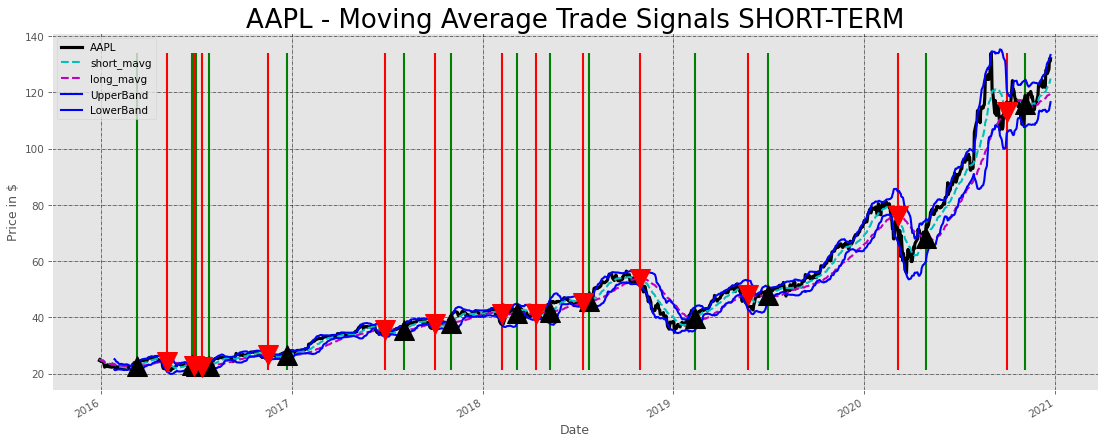

Time To Buy:
   Date
2016-03-10     22.865499
2016-06-23     22.928803
2016-06-30     22.603487
2016-07-25     22.709857
2016-12-21     26.734305
2017-08-02     35.644844
2017-11-01     38.080231
2018-03-08     41.473839
2018-05-10     42.077014
2018-07-24     45.776605
2019-02-12     39.694271
2019-07-01     47.853266
2020-04-30     68.064735
2020-11-05    116.037806
Name: short_mavg, dtype: float64


Time To Sell: 
 Date
2016-05-05     24.078282
2016-06-27     22.749335
2016-07-11     22.404456
2016-11-15     26.526391
2017-06-27     35.476861
2017-10-02     37.658687
2018-02-06     41.319866
2018-04-13     41.324315
2018-07-11     45.300958
2018-10-29     53.778826
2019-05-24     47.971270
2020-03-06     75.935437
2020-10-02    112.854298
Name: short_mavg, dtype: float64 



,signal,AAPL,short_mavg,long_mavg,UpperBand,LowerBand,positions
Date,,,,,,,
2015-12-28,0.0,24.741419,24.741419,24.741419,NaN,NaN,NaN
2015-12-29,0.0,25.186125,24.963772,24.963772,NaN,NaN,0.0
2015-12-30,0.0,24.857229,24.928258,24.928258,NaN,NaN,0.0
2015-12-31,0.0,24.380093,24.791216,24.791216,NaN,NaN,0.0
2016-01-04,0.0,24.400942,24.713161,24.713161,NaN,NaN,0.0
...,...,...,...,...,...,...,...
2020-12-18,1.0,126.660004,121.870499,118.869322,130.529654,113.211345,0.0
2020-12-21,1.0,128.229996,122.414999,119.098551,131.242560,113.587439,0.0
2020-12-22,1.0,131.880005,123.316500,119.252436,132.143739,114.489261,0.0


In [52]:
if __name__ == "__main__":
    mavg = MovingAverageGenerator()
    mavg.mAvg_trading_signals(ticker = 'AAPL') 
    # mavg.gainers()
    # mavg.losers()

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import talib
import yfinance as yf

spy = yf.download('SPY', period='5y', interval='1d', index_col='Date',parse_dates=True)
spy.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-18,370.970001,371.149994,367.019989,369.179993,369.179993,136542300
2020-12-21,364.970001,378.459991,362.029999,367.859985,367.859985,96386700
2020-12-22,368.209991,368.329987,366.029999,367.239990,367.239990,47949000
2020-12-23,368.279999,369.619995,367.220001,367.570007,367.570007,46201400
2020-12-24,368.079987,369.029999,367.450012,369.000000,369.000000,26457900


In [94]:
fig = plt.figure(figsize=(18, 7), dpi = 75)
ax1 = fig.add_subplot(111,  ylabel='Price in $')
plt.plot(spy[['Close', 'sma2', 'sma20']])
plt.title('SPY Close Prices & Simple Moving Average SMA(5)')
plt.legend(['Close', 'sma2', 'sma20'], loc='upper left')
plt.show();

from ta.volatility import BollingerBands
indicator_bb = BollingerBands(close=spy["Close"], window=20, window_dev=2)

fd = pd.DataFrame()
fd['actual'] = spy.Close
fd['bb_bbm'] = indicator_bb.bollinger_mavg()
fd['bb_bbh'] = indicator_bb.bollinger_hband()
fd['bb_bbl'] = indicator_bb.bollinger_lband()
fd['bb_bbhi'] = indicator_bb.bollinger_hband_indicator()
fd['bb_bbli'] = indicator_bb.bollinger_lband_indicator()

fig = plt.figure(figsize=(18, 7), dpi = 75)
ax = fig.add_subplot(111,  ylabel='Price in $')
plt.plot(fd[['actual', 'bb_bbm', 'bb_bbh', 'bb_bbl']])
plt.legend(['actual', 'bb_bbm', 'bb_bbh', 'bb_bbl'], loc='upper left');

KeyError: "['sma20', 'sma2'] not in index"

NameError: name 'spy' is not defined

In [67]:
fd

,actual,bb_bbm,bb_bbh,bb_bbl,bb_bbhi,bb_bbli
Date,,,,,,
2015-12-28,205.210007,NaN,NaN,NaN,0.0,0.0
2015-12-29,207.399994,NaN,NaN,NaN,0.0,0.0
2015-12-30,205.929993,NaN,NaN,NaN,0.0,0.0
2015-12-31,203.869995,NaN,NaN,NaN,0.0,0.0
2016-01-04,201.020004,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...
2020-12-18,369.179993,365.936501,374.325361,357.547640,0.0,0.0
2020-12-21,367.859985,366.563000,373.421812,359.704189,0.0,0.0
2020-12-22,367.239990,367.052000,372.493096,361.610904,0.0,0.0


In [87]:
import pandas as pd
import numpy as np
import yfinance
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 7]
plt.rc('font', size=14)

In [88]:
name = 'SPY'
ticker = yfinance.Ticker(name)
df = ticker.history(interval="1d",start="2020-03-15", end="2020-07-15")
df['Date'] = pd.to_datetime(df.index)
df['Date'] = df['Date'].apply(mpl_dates.date2num)
df = df.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]


def isSupport(df,i):
  support = df['Low'][i] < df['Low'][i-1]  and df['Low'][i] < df['Low'][i+1] \
  and df['Low'][i+1] < df['Low'][i+2] and df['Low'][i-1] < df['Low'][i-2]
  return support

def isResistance(df,i):
  resistance = df['High'][i] > df['High'][i-1]  and df['High'][i] > df['High'][i+1] \
  and df['High'][i+1] > df['High'][i+2] and df['High'][i-1] > df['High'][i-2] 
  return resistance


levels = []
for i in range(2,df.shape[0]-2):
    if isSupport(df,i):
        levels.append((i,df['Low'][i]))
    elif isResistance(df,i):
        levels.append((i,df['High'][i]))


def plot_all():
    fig, ax = plt.subplots()
    candlestick_ohlc(ax,df.values,width=0.6, colorup='green', colordown='red', alpha=0.8)
    date_format = mpl_dates.DateFormatter('%d %b %Y')
    ax.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()
    fig.tight_layout()
    for level in levels:
        plt.hlines(level[1],xmin=df['Date'][level[0]], xmax=max(df['Date']),colors='blue')
    fig.show()

s =  np.mean(df['High'] - df['Low'])

def isFarFromLevel(l):
    return np.sum([abs(l-x) < s  for x in levels]) == 0

levels = []
for i in range(2,df.shape[0]-2):
    if isSupport(df,i):
        l = df['Low'][i]
        if isFarFromLevel(l):
            levels.append((i,l))
    elif isResistance(df,i):
        l = df['High'][i]
        if isFarFromLevel(l):
            levels.append((i,l))
# levels

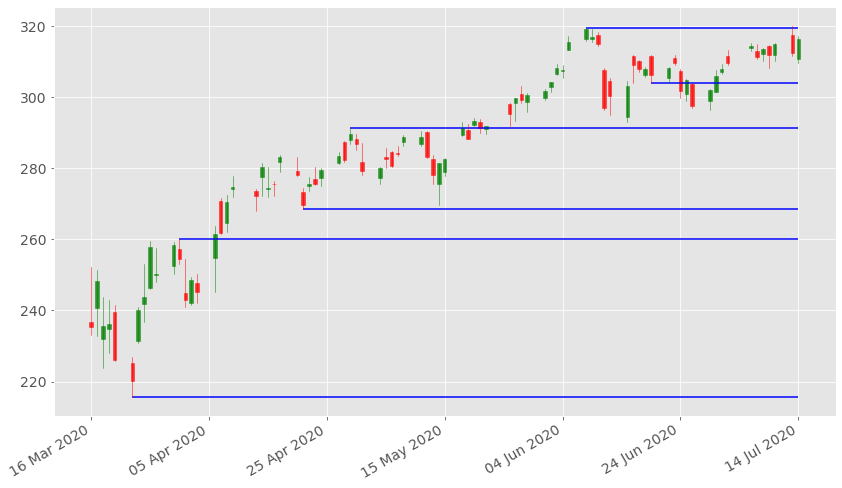

In [89]:
plot_all()

In [75]:
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web

def MovingAverageCrossStrategy(
    stock_symbol = 'aapl', 
    short_window = 2, long_window = 20, 
    start_date = '2020-01-01', end_date = '2020-12-24', 
    moving_avg = 'SMA', display_table = True
    ):
    
    start = datetime.datetime(*map(int, start_date.split('-')))
    end = datetime.datetime(*map(int, end_date.split('-'))) 
    stock_df = web.DataReader(stock_symbol, 'yahoo', start = start, end = end)['Close']
    stock_df = pd.DataFrame(stock_df) # convert Series object to dataframe 
    stock_df.columns = {stock_symbol} # assign new colun name
    stock_df.dropna(axis = 0, inplace = True) # remove any null rows 
                        
    # column names for long and short moving average columns
    short_window_col = str(short_window) + '_' + moving_avg
    long_window_col = str(long_window) + '_' + moving_avg  
  
    if moving_avg == 'SMA':
        stock_df[short_window_col] = stock_df[stock_symbol].rolling(window = short_window, min_periods = 1).mean()
        stock_df[long_window_col] = stock_df[stock_symbol].rolling(window = long_window, min_periods = 1).mean()

    elif moving_avg == 'EMA':
        stock_df[short_window_col] = stock_df[stock_symbol].ewm(span = short_window, adjust = False).mean()
        stock_df[long_window_col] = stock_df[stock_symbol].ewm(span = long_window, adjust = False).mean()

    # create a new column 'Signal' such that if faster moving average is greater than slower moving average set Signal as 1 else 0.
    stock_df['Signal'] = 0.0  
    stock_df['Signal'] = np.where(stock_df[stock_symbol] > stock_df[long_window_col], 1.0, 0.0) 
    # create a new column 'Position' which is a day-to-day difference of the 'Signal' column. 
    stock_df['Position'] = stock_df['Signal'].diff()

    # plot close price, short-term and long-term moving averages
    plt.figure(figsize = (20,5))
    plt.tick_params(axis = 'both', labelsize = 14)
    stock_df[stock_symbol].plot(color = 'k', lw = 1, label = stock_symbol)  
    stock_df[short_window_col].plot(color = 'b', lw = 1, label = short_window_col)
    stock_df[long_window_col].plot(color = 'g', lw = 1, label = long_window_col) 
    # plot 'buy' signals
    plt.plot(stock_df[stock_df['Position'] == 1].index, stock_df[
        short_window_col][stock_df['Position'] == 1],'^', markersize = 15, color = 'g', alpha = 0.7, label = 'buy')
    # plot 'sell' signals
    plt.plot(stock_df[stock_df['Position'] == -1].index, stock_df[
        short_window_col][stock_df['Position'] == -1], 'v', markersize = 15, color = 'r', alpha = 0.7, label = 'sell')
    plt.ylabel('Price in ₹', fontsize = 16 )
    plt.xlabel('Date', fontsize = 16 )
    plt.title(str(stock_symbol) + ' - ' + str(moving_avg) + ' Crossover', fontsize = 20)
    plt.legend()
    plt.grid()
    plt.show()
    
    if display_table == True:
        df_pos = stock_df[(stock_df['Position'] == 1) | (stock_df['Position'] == -1)]
        df_pos['Position'] = df_pos['Position'].apply(lambda x: 'Buy' if x == 1 else 'Sell')
        # print(tabulate(df_pos, headers = 'keys', tablefmt = 'psql'))
        Table = tabulate(df_pos, headers = 'keys', tablefmt = 'psql')

    return stock_df, Table

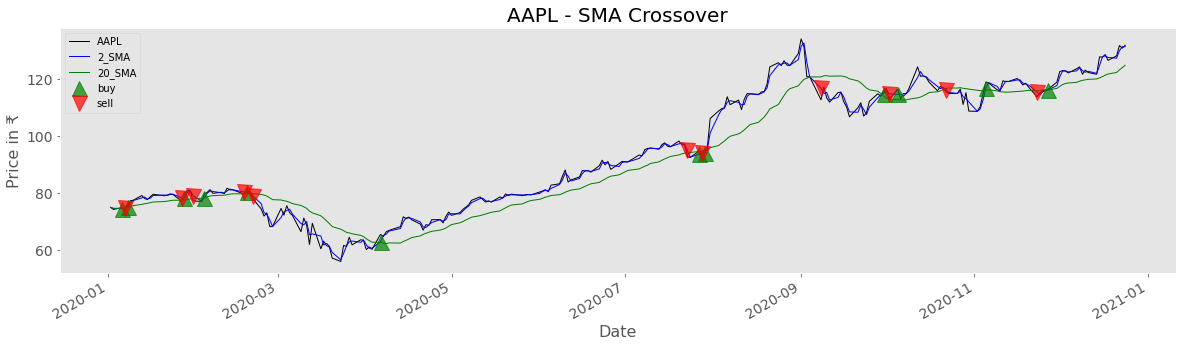

In [76]:
stock_df, table = MovingAverageCrossStrategy('AAPL',2,20)

In [84]:
print(table)

+---------------------+----------+----------+----------+----------+------------+
| Date                |     AAPL |    2_SMA |   20_SMA |   Signal | Position   |
|---------------------+----------+----------+----------+----------+------------|
| 2020-01-06 00:00:00 |  74.95   |  74.6537 |  74.7983 |        1 | Buy        |
| 2020-01-07 00:00:00 |  74.5975 |  74.7738 |  74.7481 |        0 | Sell       |
| 2020-01-08 00:00:00 |  75.7975 |  75.1975 |  74.958  |        1 | Buy        |
| 2020-01-27 00:00:00 |  77.2375 |  78.4075 |  77.571  |        0 | Sell       |
| 2020-01-28 00:00:00 |  79.4225 |  78.33   |  77.6739 |        1 | Buy        |
| 2020-01-31 00:00:00 |  77.3775 |  79.1725 |  78.1236 |        0 | Sell       |
| 2020-02-04 00:00:00 |  79.7125 |  78.4388 |  78.5021 |        1 | Buy        |
| 2020-02-18 00:00:00 |  79.75   |  80.4938 |  79.8444 |        0 | Sell       |
| 2020-02-19 00:00:00 |  80.905  |  80.3275 |  79.9325 |        1 | Buy        |
| 2020-02-21 00:00:00 |  78.

In [81]:
stock_df

,AAPL,2_SMA,20_SMA,Signal,Position
Date,,,,,
2020-01-02,75.087502,75.087502,75.087502,0.0,NaN
2020-01-03,74.357498,74.722500,74.722500,0.0,0.0
2020-01-06,74.949997,74.653748,74.798332,1.0,1.0
2020-01-07,74.597504,74.773750,74.748125,0.0,-1.0
2020-01-08,75.797501,75.197502,74.958000,1.0,1.0
...,...,...,...,...,...
2020-12-18,126.660004,127.680000,121.870499,1.0,0.0
2020-12-21,128.229996,127.445000,122.414999,1.0,0.0
2020-12-22,131.880005,130.055000,123.316500,1.0,0.0
